In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'relu',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

relu_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 831)
(631390, 1)
validation
(74368, 831)
(74368, 1)
test
(85358, 831)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1541121 (5.88 MB)


Trainable params: 1541121 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:12 - loss: 0.0638 - STD: 0.0124 - MAE: 0.2432

 5/64 [=>............................] - ETA: 0s - loss: 0.0615 - STD: 0.0143 - MAE: 0.2107  

 7/64 [==>...........................] - ETA: 5s - loss: 0.0529 - STD: 0.0154 - MAE: 0.1815

10/64 [===>..........................] - ETA: 3s - loss: 0.0477 - STD: 0.0156 - MAE: 0.1743

14/64 [=====>........................] - ETA: 2s - loss: 0.0375 - STD: 0.0195 - MAE: 0.1520

18/64 [=======>......................] - ETA: 2s - loss: 0.0310 - STD: 0.0233 - MAE: 0.1308

22/64 [=========>....................] - ETA: 1s - loss: 0.0265 - STD: 0.0301 - MAE: 0.1186

26/64 [===========>..................] - ETA: 1s - loss: 0.0233 - STD: 0.0377 - MAE: 0.1087

30/64 [=============>................] - ETA: 1s - loss: 0.0209 - STD: 0.0449 - MAE: 0.1014

34/64 [==============>...............] - ETA: 0s - loss: 0.0189 - STD: 0.0511 - MAE: 0.0952

38/64 [================>.............] - ETA: 0s - loss: 0.0174 - STD: 0.0548 - MAE: 0.0901

42/64 [==================>...........] - ETA: 0s - loss: 0.0161 - STD: 0.0584 - MAE: 0.0857

46/64 [====================>.........] - ETA: 0s - loss: 0.0150 - STD: 0.0620 - MAE: 0.0819

50/64 [======================>.......] - ETA: 0s - loss: 0.0141 - STD: 0.0644 - MAE: 0.0786

54/64 [========================>.....] - ETA: 0s - loss: 0.0133 - STD: 0.0669 - MAE: 0.0756

58/64 [==========================>...] - ETA: 0s - loss: 0.0126 - STD: 0.0689 - MAE: 0.0729

62/64 [============================>.] - ETA: 0s - loss: 0.0119 - STD: 0.0709 - MAE: 0.0705

64/64 [==============================] - 3s 32ms/step - loss: 0.0117 - STD: 0.0719 - MAE: 0.0694 - val_loss: 0.0044 - val_STD: 0.0682 - val_MAE: 0.0391


Epoch 2/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0928 - MAE: 0.0360

 6/64 [=>............................] - ETA: 0s - loss: 0.0029 - STD: 0.0982 - MAE: 0.0354

10/64 [===>..........................] - ETA: 0s - loss: 0.0029 - STD: 0.0981 - MAE: 0.0351

14/64 [=====>........................] - ETA: 0s - loss: 0.0028 - STD: 0.0991 - MAE: 0.0349

18/64 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.0987 - MAE: 0.0344

22/64 [=========>....................] - ETA: 0s - loss: 0.0027 - STD: 0.0993 - MAE: 0.0342

26/64 [===========>..................] - ETA: 0s - loss: 0.0026 - STD: 0.0991 - MAE: 0.0339

30/64 [=============>................] - ETA: 0s - loss: 0.0026 - STD: 0.0994 - MAE: 0.0336

34/64 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.0998 - MAE: 0.0334

38/64 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.0999 - MAE: 0.0331

42/64 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1002 - MAE: 0.0329

46/64 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1003 - MAE: 0.0327

50/64 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1007 - MAE: 0.0326

54/64 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1008 - MAE: 0.0326

58/64 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1008 - MAE: 0.0325

62/64 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1012 - MAE: 0.0324

64/64 [==============================] - 1s 18ms/step - loss: 0.0023 - STD: 0.1011 - MAE: 0.0324 - val_loss: 0.0030 - val_STD: 0.0985 - val_MAE: 0.0374


Epoch 3/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0024 - STD: 0.1176 - MAE: 0.0332

 5/64 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.1051 - MAE: 0.0309

 9/64 [===>..........................] - ETA: 0s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0307

13/64 [=====>........................] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0304

17/64 [======>.......................] - ETA: 0s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0302

21/64 [========>.....................] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0299

25/64 [==========>...................] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0298

29/64 [============>.................] - ETA: 0s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0296

33/64 [==============>...............] - ETA: 0s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0295

37/64 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0294

42/64 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0292

46/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0292

50/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0292

54/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0291

58/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0291

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0290

64/64 [==============================] - 1s 18ms/step - loss: 0.0018 - STD: 0.1042 - MAE: 0.0290 - val_loss: 0.0018 - val_STD: 0.0923 - val_MAE: 0.0297


Epoch 4/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

 5/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0277

 9/64 [===>..........................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

13/64 [=====>........................] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

17/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0277

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0277

25/64 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278

30/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

34/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0282

38/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

42/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

46/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

64/64 [==============================] - 1s 18ms/step - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282 - val_loss: 0.0017 - val_STD: 0.0878 - val_MAE: 0.0286


Epoch 5/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.0969 - MAE: 0.0289

 5/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0278

 9/64 [===>..........................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

14/64 [=====>........................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0279

18/64 [=======>......................] - ETA: 0s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0281

22/64 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0279

26/64 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0279

30/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

34/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0279

38/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

64/64 [==============================] - 1s 17ms/step - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276 - val_loss: 0.0016 - val_STD: 0.0918 - val_MAE: 0.0279


Epoch 6/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0264

10/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0274

14/64 [=====>........................] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0276

18/64 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

22/64 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

26/64 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

30/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

38/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0271

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

64/64 [==============================] - 1s 17ms/step - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271 - val_loss: 0.0015 - val_STD: 0.0910 - val_MAE: 0.0277


Epoch 7/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0278

 5/64 [=>............................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

 9/64 [===>..........................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

13/64 [=====>........................] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

17/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

21/64 [========>.....................] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

29/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

64/64 [==============================] - 1s 17ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266 - val_loss: 0.0023 - val_STD: 0.0801 - val_MAE: 0.0336


Epoch 8/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0029 - STD: 0.0879 - MAE: 0.0383

 5/64 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0317

 9/64 [===>..........................] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0302

13/64 [=====>........................] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0295

18/64 [=======>......................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0291

22/64 [=========>....................] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0291

26/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0290

30/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0292

34/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0290

38/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0289

42/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0288

46/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0286

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0283

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0279

64/64 [==============================] - 1s 17ms/step - loss: 0.0016 - STD: 0.1047 - MAE: 0.0279 - val_loss: 0.0014 - val_STD: 0.0916 - val_MAE: 0.0270


Epoch 9/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0270

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0260

 8/64 [==>...........................] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

12/64 [====>.........................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

16/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

20/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

24/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

32/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

36/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

64/64 [==============================] - 1s 17ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258 - val_loss: 0.0021 - val_STD: 0.1007 - val_MAE: 0.0307


Epoch 10/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1094 - MAE: 0.0261

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0259

 8/64 [==>...........................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

12/64 [====>.........................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

16/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

20/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

24/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

32/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

36/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

64/64 [==============================] - 1s 17ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260 - val_loss: 0.0023 - val_STD: 0.1003 - val_MAE: 0.0322


Epoch 11/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1094 - MAE: 0.0268

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

 9/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0271

17/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0274

22/64 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0276

26/64 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0278

30/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0278

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

38/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0275

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0272

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

64/64 [==============================] - 1s 17ms/step - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270 - val_loss: 0.0018 - val_STD: 0.0994 - val_MAE: 0.0292


Epoch 12/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1101 - MAE: 0.0254

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1075 - MAE: 0.0255

 8/64 [==>...........................] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

12/64 [====>.........................] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

16/64 [======>.......................] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

20/64 [========>.....................] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0254

24/64 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0254

28/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0253

32/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

36/64 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

40/64 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

44/64 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

48/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

64/64 [==============================] - 1s 17ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254 - val_loss: 0.0019 - val_STD: 0.0989 - val_MAE: 0.0292


Epoch 13/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1090 - MAE: 0.0255

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0258

 9/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0255

21/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

26/64 [===========>..................] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0253

30/64 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0253

34/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0252

38/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0253

42/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0253

46/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0253

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0253

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

64/64 [==============================] - 1s 17ms/step - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251 - val_loss: 0.0018 - val_STD: 0.1002 - val_MAE: 0.0288


Epoch 14/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1097 - MAE: 0.0250

 5/64 [=>............................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

 9/64 [===>..........................] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0251

13/64 [=====>........................] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0252

17/64 [======>.......................] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

21/64 [========>.....................] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0251

25/64 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

29/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

33/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

37/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

41/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

45/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0254

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0254

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0255

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0255

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

64/64 [==============================] - 1s 17ms/step - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254 - val_loss: 0.0016 - val_STD: 0.0971 - val_MAE: 0.0273


Epoch 15/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0241

 5/64 [=>............................] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

 9/64 [===>..........................] - ETA: 0s - loss: 0.0012 - STD: 0.1060 - MAE: 0.0244

13/64 [=====>........................] - ETA: 0s - loss: 0.0012 - STD: 0.1062 - MAE: 0.0244

17/64 [======>.......................] - ETA: 0s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0244

21/64 [========>.....................] - ETA: 0s - loss: 0.0012 - STD: 0.1061 - MAE: 0.0244

25/64 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0248

29/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0248

33/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0248

37/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

41/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

45/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

64/64 [==============================] - 1s 17ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0254 - val_loss: 0.0015 - val_STD: 0.0950 - val_MAE: 0.0268


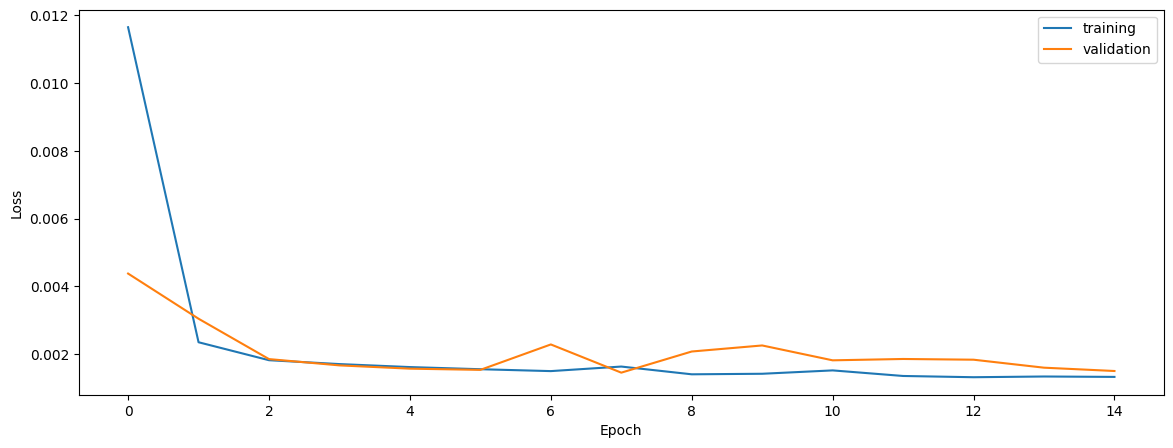

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


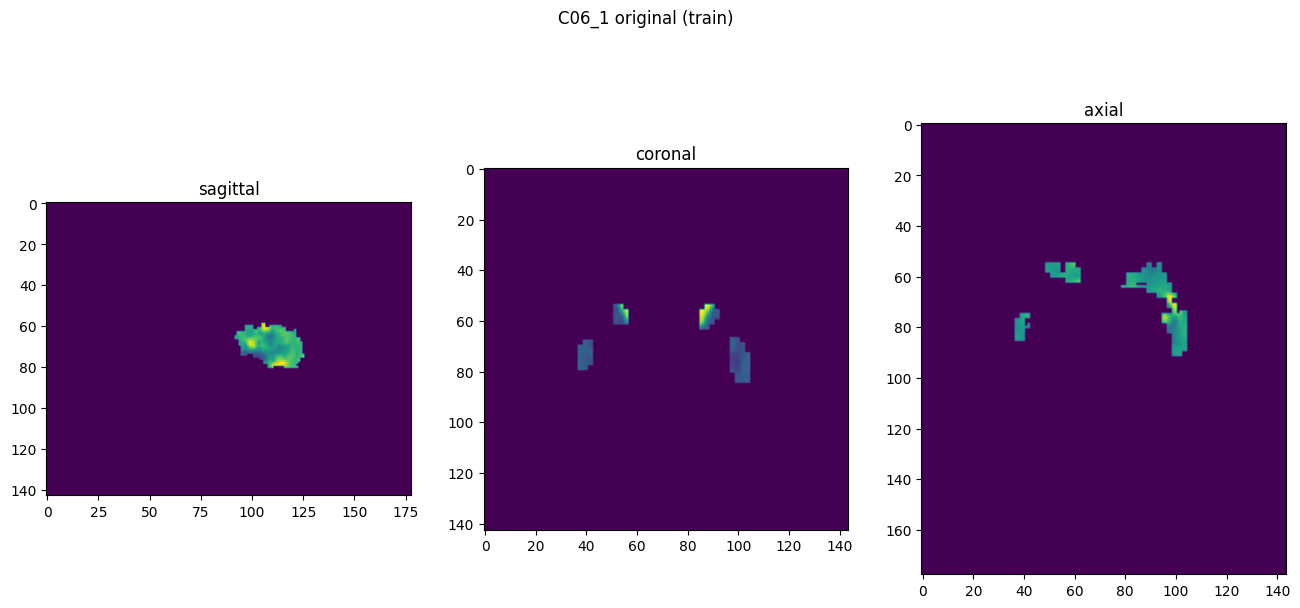

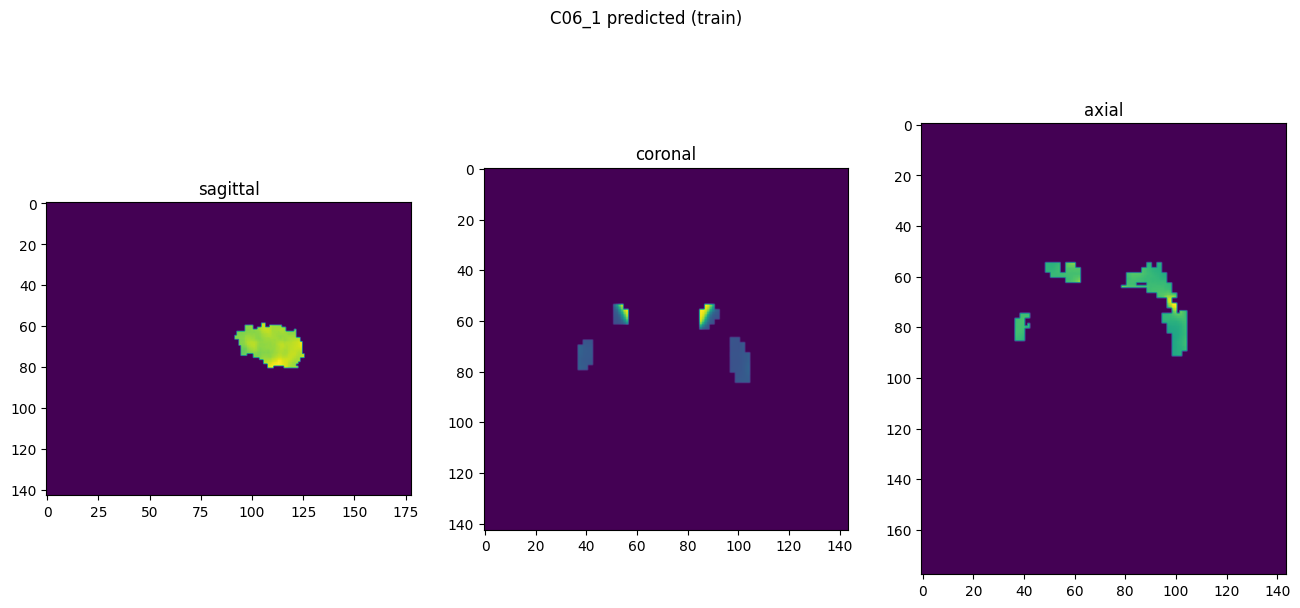

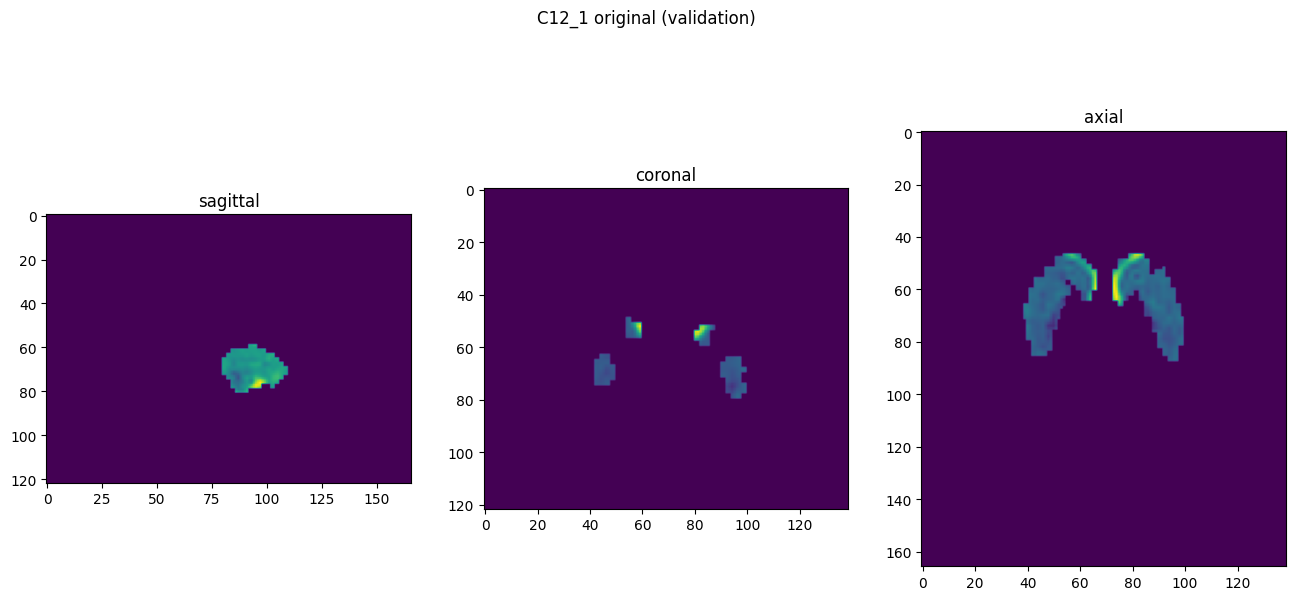

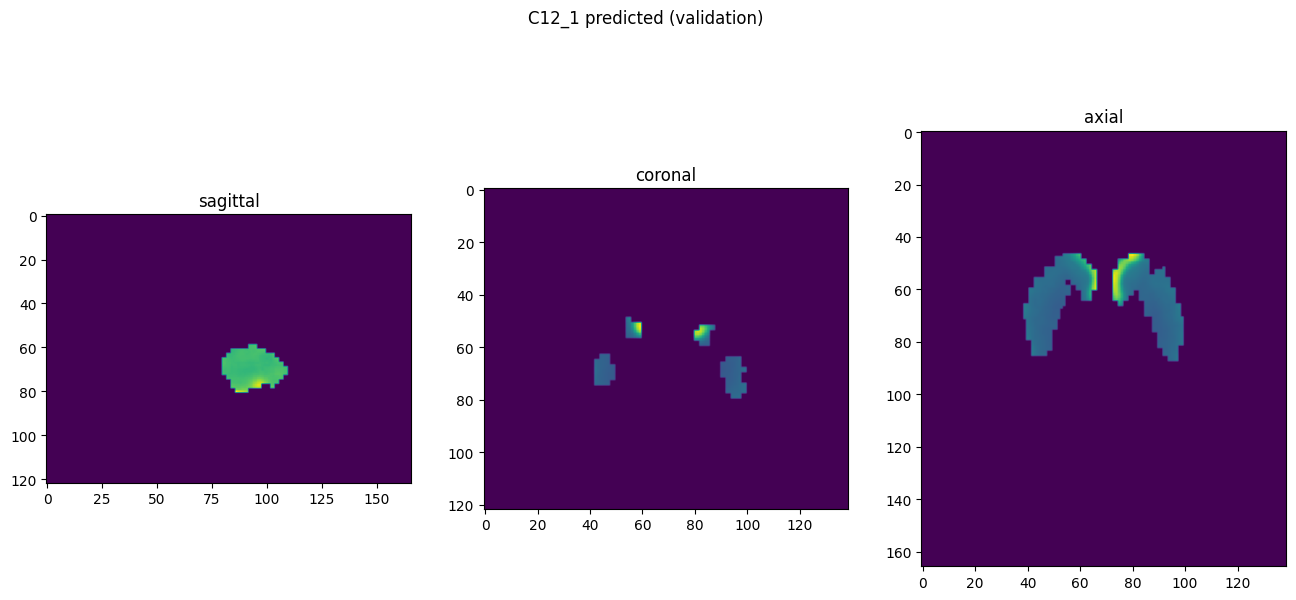

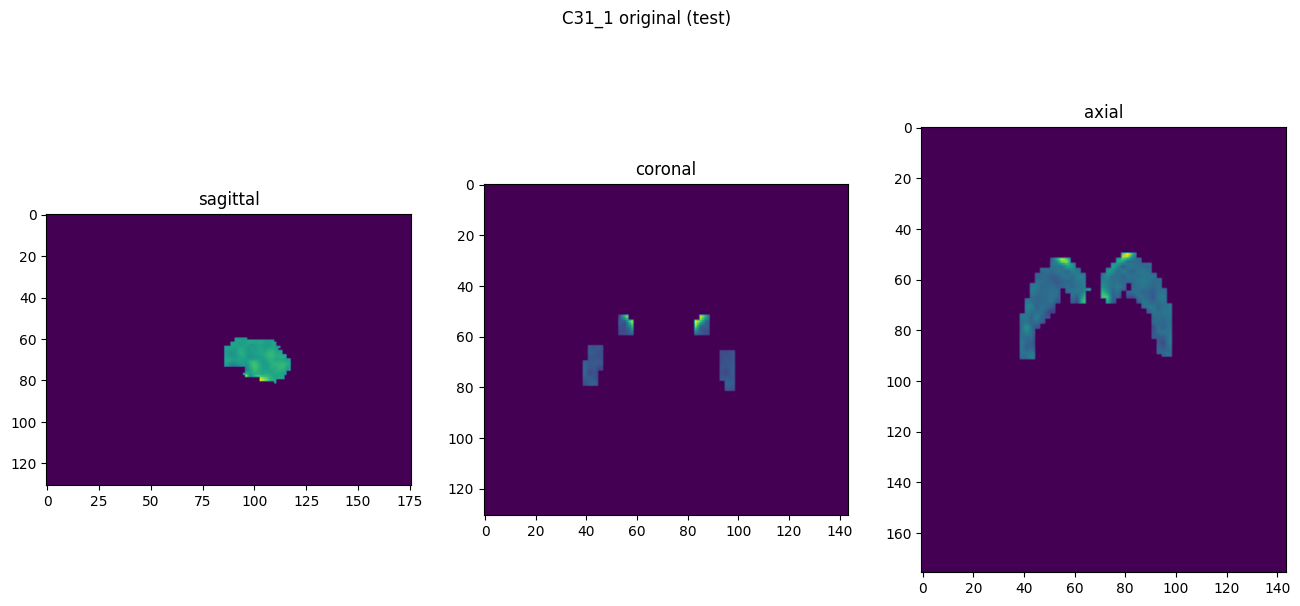

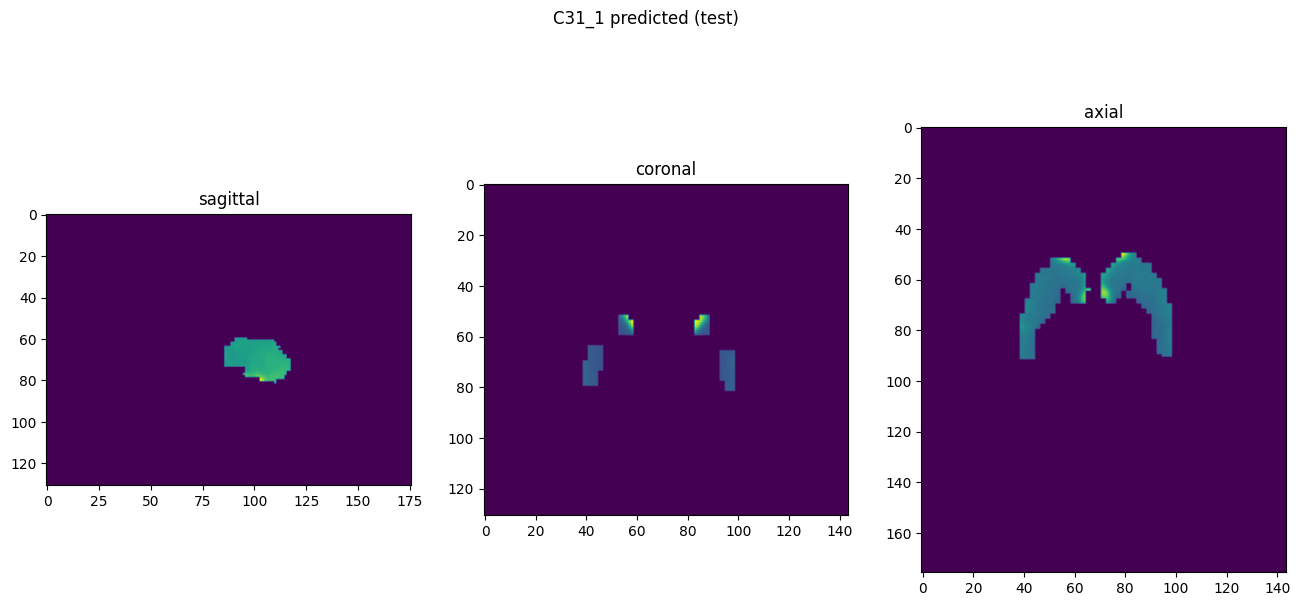

In [10]:
showResults(model, gen, threshold=None, background=False)